# Gaussian Process Auto-Regressive Model (GPAR)

The GPAR model is formed by assuming a "closed downward" dependence structure for the data, i.e. if $(x, y_i) \in D$ that $(x, y_j) \in D$ for all $j \le i$. We then write the joint as a factored model,

$$
p(y_1, \ldots, y_n) = p(y_1) p(y_2 | y_1) \ldots p(y_n | y_{n-1}, y_{n-2}, \ldots, y_1)
$$
where each $y_i$ is assumed to be a Gaussian process, and given noise variances $\sigma_i^2$. The input to each GP is are the coordinates and the posterior mean of all preceding dimensions.


In [1]:
# For Gaussian processes 64bit is important
from jax.config import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from typing import Tuple, Dict, NamedTuple

import haiku as hk

from jax import tree_map
from jax import random
from jax import numpy as jnp
from jax.scipy.linalg import solve_triangular

import pylab as plt

from jaxns import Prior, Model
from jaxns.utils import marginalise_static_from_U, evaluate_map_estimate_from_U

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

INFO[2023-12-11 13:08:33,937]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:08:33,937]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:08:33,938]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 13:08:33,939]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


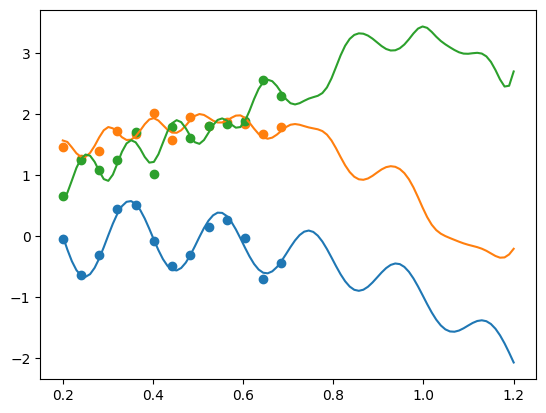

In [2]:
# Create toy data set.
n = 100
x = jnp.linspace(0.2, 1.2, n)
noise = 0.1

# Draw functions depending on each other in complicated ways.
f1 = -jnp.sin(10 * jnp.pi * (x + 1)) / (2 * x + 1) - x ** 4
f2 = jnp.cos(f1) ** 2 + jnp.sin(3 * x)
f3 = f2 * f1 ** 2 + 3 * x
f = jnp.stack((f1, f2, f3), axis=1)

# Add noise and subsample.
y = f + noise * random.normal(random.PRNGKey(42), shape=(n, 3))
x_obs, y_obs = x[:n // 2:4], y[:n // 2:4]
y_obs_var = jnp.ones(y_obs.shape) * noise ** 2

for i in range(3):
    plt.plot(x, f[:, i], label='f{}'.format(i))
    plt.scatter(x_obs, y_obs[:, i], label='y{}'.format(i))

plt.show()


In [3]:



from jaxns.internals.types import float_type
from typing import List


def log_normal_with_mask(x, mean, cov, sigma):
    """
    Computes log-Normal density in a numerically stable way so that sigma can contain +inf for masked data.

    Args:
        x: RV value
        mean: mean of Gaussian
        cov: covariance of underlying, minus the obs. covariance
        sigma: stddev's of obs. error, inf encodes an outlier.

    Returns: a normal density for all points not of inf stddev obs. error.
    """
    C = cov / (sigma[:, None] * sigma[None, :]) + jnp.eye(cov.shape[0])
    L = jnp.linalg.cholesky(C)
    Ls = sigma[:, None] * L
    log_det = jnp.sum(jnp.where(jnp.isinf(sigma), 0., jnp.log(jnp.diag(Ls))))
    dx = (x - mean)
    dx = solve_triangular(L, dx / sigma, lower=True)
    maha = dx @ dx
    log_likelihood = -0.5 * jnp.sum(~jnp.isinf(sigma)) * jnp.log(2. * jnp.pi) \
                     - log_det \
                     - 0.5 * maha
    return log_likelihood


class GaussianProcessData(NamedTuple):
    X: List[jnp.ndarray]
    Y: jnp.ndarray
    Y_var: jnp.ndarray
    sample_size: jnp.ndarray


def _assert_rank(rank: int, **kwargs):
    for name, t in kwargs.items():
        if len(t.shape) != rank:
            raise ValueError(f"{name} shoue be rank {rank} got {t.shape}.")


def _assert_same_leading_dim(*args):
    n = set()
    for arg in args:
        n.add(arg.shape[0])
    if len(n) > 1:
        raise ValueError(f"Got mismatched leading dimensions: {n}")


def _ensure_gaussian_process_data(data: GaussianProcessData) -> GaussianProcessData:
    data = tree_map(lambda x: jnp.asarray(x, float_type), data)
    _assert_rank(2, U=data.X)
    _assert_rank(1, sample_size=data.sample_size, Y=data.Y, Y_var=data.Y_var)
    _assert_same_leading_dim(*data)
    if data.Y.shape[0] < 2:
        raise ValueError('Need more samples to form mean and variance of data.')
    return data


def eval_kernels(kernels: List[tfp.math.psd_kernels.PositiveSemidefiniteKernel | None], X1: List[jnp.ndarray],
                 X2: List[jnp.ndarray]):
    """
    Evaluates the kernel function between the coordinates X1 and X2.
    
    Args:
        kernels: The kernel functions.
        X1: The first set of coordinates.
        X2: The second set of coordinates.

    Returns:
        The kernel matrix.
    """
    kernels = list(filter(lambda x: x is not None, kernels))
    assert len(kernels) == len(X1) == len(X2), f"Got {len(kernels)} kernels, {len(X1)} X1, {len(X2)} X2. {kernels}"
    Ks = [kernel.matrix(x1, x2) for kernel, x1, x2 in zip(kernels, X1, X2)]
    return sum(Ks[1:], Ks[0])


def marginal_likelihood_with_mask(kernels: List[tfp.math.psd_kernels.PositiveSemidefiniteKernel | None],
                                  data: GaussianProcessData,
                                  variance: jnp.ndarray,
                                  mean: jnp.ndarray) -> jnp.ndarray:
    Kxx = eval_kernels(kernels, data.X, data.X)
    no_uncert_data = jnp.isnan(data.Y_var)

    variance = jnp.where(no_uncert_data,
                         variance,
                         data.Y_var)

    sigma = jnp.sqrt(jnp.maximum(1e-6, variance))
    return log_normal_with_mask(x=data.Y, mean=mean, cov=Kxx, sigma=sigma)


def posterior_with_mask(Xstar: List[jnp.ndarray],
                        kernels: List[tfp.math.psd_kernels.PositiveSemidefiniteKernel | None],
                        data: GaussianProcessData,
                        variance: jnp.ndarray,
                        mean: jnp.ndarray,
                        cov: bool = False) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Computes the posterior mean and variance of a Gaussian process, given the data, and a mask.

    Args:
        Xstar: List of input coordinates [H, D_i]
        kernels: The kernel functions.
        data: The data, where masked data has inf variance.
        variance: The variance of the posterior mean.
        mean: The posterior mean.
        cov: If True, return the full covariance matrix, otherwise return the diagonal.

    Returns:
        The posterior mean, and variance of the data
    """

    Kxx = eval_kernels(kernels, data.X, data.X)
    Kxs = eval_kernels(kernels, data.X, Xstar)
    Kss = eval_kernels(kernels, Xstar, Xstar)

    variance = data.Y_var
    std_dev = jnp.sqrt(jnp.maximum(1e-6, variance))

    L = jnp.linalg.cholesky(Kxx / (std_dev[:, None] * std_dev[None, :]) + jnp.eye(std_dev.size))
    # L = jnp.where(jnp.isnan(L), jnp.eye(L.shape[0])/sigma, L)

    J = solve_triangular(L, Kxs / std_dev[:, None],
                         lower=True)  # same J as below, but safely taking into account inf mask.

    post_cov_s = Kss - J.T @ J

    dY = data.Y - mean
    dX = solve_triangular(L, dY / std_dev, lower=True)
    post_mu_s = mean + J.T @ dX  # mu + J^T L^-1 dY = mu - J^T dX

    if cov:
        return post_mu_s, post_cov_s
    return post_mu_s, jnp.diag(post_cov_s)


In [4]:




from jaxns.internals.types import NestedSamplerResults
from jaxns.experimental import ParametrisedModel, EvidenceMaximisation, prior_to_parametrised_singular
from jaxns import summary, plot_diagnostics, plot_cornerplot
from typing import List


class Normaliser:
    """
    Normalises data to zero mean and unit variance.
    """

    def __init__(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        self.X = X
        self.Y = Y
        self.Y_var = Y_var

    @property
    def normalisation_params(self) -> Dict[str, jnp.ndarray]:
        """
        Computes the normalisation parameters for the data.

        Returns:
            A dictionary containing the normalisation parameters.
        """
        X_loc = jnp.nanmean(self.X, axis=0, keepdims=True)
        X_scale = jnp.nanstd(self.X, axis=0, keepdims=True)
        Y_loc = jnp.nanmean(self.Y, axis=0, keepdims=True)
        Y_scale = jnp.nanstd(self.Y, axis=0, keepdims=True)
        return dict(
            X_loc=X_loc,
            X_scale=X_scale,
            Y_loc=Y_loc,
            Y_scale=Y_scale
        )

    def normalise_X(self, X: jnp.ndarray):
        return (X - self.normalisation_params['X_loc']) / self.normalisation_params['X_scale']

    def normalise_Y(self, Y: jnp.ndarray):
        return (Y - self.normalisation_params['Y_loc']) / self.normalisation_params['Y_scale']

    def normalise_Y_var(self, Y_var: jnp.ndarray):
        return Y_var / jnp.square(self.normalisation_params['Y_scale'])

    def normalise_data(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        return self.normalise_X(X), self.normalise_Y(Y), self.normalise_Y_var(Y_var)

    def unnormalise_X(self, X: jnp.ndarray):
        return X * self.normalisation_params['X_scale'] + self.normalisation_params['X_loc']

    def unnormalise_Y(self, Y: jnp.ndarray):
        return Y * self.normalisation_params['Y_scale'] + self.normalisation_params['Y_loc']

    def unnormalise_Y_var(self, Y_var: jnp.ndarray):
        return Y_var * jnp.square(self.normalisation_params['Y_scale'])

    def unnormlise_data(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray):
        return self.unnormalise_X(X), self.unnormalise_Y(Y), self.unnormalise_Y_var(Y_var)


class GPAR:
    def __init__(self, X: jnp.ndarray, Y: jnp.ndarray, Y_var: jnp.ndarray, markov_ndims: int = None,
                 replace: bool = False, impute: bool = False):
        """
        Gaussian Process Auto-Regressive Model (GPAR) for M-dimensional data.

        Args:
            X: The input coordinates [N, D]
            Y: The data values [N, M]
            Y_var: The variance of the data values [N, M]
            markov_ndims: The number of dimensions to condition on. If None, all preceding dimensions are conditioned on.
            replace: If True, replace the data with the posterior mean of the previous conditional.
            impute: If True, impute missing data using the posterior mean of the previous conditional. 
                Missing data have Y_var[i, j] == inf or Y[i, j] == nan.
        """
        self.X = X
        self.Y = Y
        self.Y_var = Y_var
        self.markov_ndims = markov_ndims
        self.normaliser = Normaliser(X, Y, Y_var)
        self.replace = replace
        self.impute = impute

    def build_model(self, params: hk.MutableParams | None) -> ParametrisedModel:
        return ParametrisedModel(
            base_model=Model(prior_model=self._build_prior_model(), log_likelihood=self._log_likelihood),
            params=params
        )

    def get_markov_dims_iterator(self):
        """
        Returns an iterator over the output dimensions which condition a given output dimension.
        
        Returns:
            An iterator that produces (i, [j, k, ...]) where i is the output dimension, and j, k, ... are the conditioning dimensions.
        """
        for i in range(self.ndims):
            last_dim = i
            first_dim = max(0, last_dim - self.markov_ndims) if self.markov_ndims is not None else 0
            conditional_dims = list(range(first_dim, last_dim))
            yield i, conditional_dims

    def _build_prior_model(self):
        # Assumes input data is normalised.

        def prior_model():
            uncerts = []
            kernel_params = []
            input_kernel_params = []

            D = self.X.shape[1]

            for (i, markov_dims) in self.get_markov_dims_iterator():
                uncert = yield Prior(tfpd.Exponential(1. / 0.2), name=f'uncert_{i}')  # [1]
                uncerts.append(uncert)

                # Non-linear

                input_length_scale = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1. / 0.1 * jnp.ones((D,))), name=f'X_length_scale_{i}')
                )  # [D]
                input_amplitude = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1. / 1.), name=f'X_amplitude_{i}')
                )  # [1]

                # Linear

                bias_amplitude = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1. / 10.), name=f'X_bias_amplitude_{i}')
                )  # [1]
                slope_amplitude = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1. / 10.), name=f'X_slope_amplitude_{i}')
                )  # [1]
                input_linear_param = dict(bias_amplitude=bias_amplitude, slope_amplitude=slope_amplitude)

                # Periodic
                input_periodic_amplitude = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1.), name=f'X_periodic_amplitude_{i}')
                )  # [1]
                input_periodic_length_scale = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1. / 0.1), name=f'X_periodic_length_scale_{i}')
                )  # [1]
                input_periodic_period = yield Prior(tfpd.Exponential(1.), name=f'X_periodic_period_{i}')  # [1]

                input_kernel_param = dict(
                    linear=input_linear_param,
                    non_linear=dict(length_scale=input_length_scale, amplitude=input_amplitude),
                    periodic=dict(length_scale=input_periodic_length_scale, amplitude=input_periodic_amplitude,
                                  period=input_periodic_period)
                )
                input_kernel_params.append(input_kernel_param)

                num_preceding_dims = len(markov_dims)
                if num_preceding_dims == 0:
                    kernel_params.append(None)
                    continue

                length_scale = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1. / 0.2 * jnp.ones((num_preceding_dims,))), name=f'length_scale_{i}')
                )  # [num_preceding_dims]
                amplitude = yield prior_to_parametrised_singular(
                    Prior(tfpd.Exponential(1.), name=f'amplitude_{i}')
                )  # [num_preceding_dims]
                nonlinear_param = dict(length_scale=length_scale, amplitude=amplitude)

                bias_amplitude = yield Prior(tfpd.Exponential(1. / 10.), name=f'bias_amplitude_{i}')  # [1]
                slope_amplitude = yield Prior(tfpd.Exponential(1. / 10.), name=f'slope_amplitude_{i}')  # [1]
                linear_param = dict(bias_amplitude=bias_amplitude, slope_amplitude=slope_amplitude)

                kernel_params.append(dict(non_linear=nonlinear_param, linear=linear_param))

            return uncerts, input_kernel_params, kernel_params

        return prior_model

    def _build_kernel(self, input_kernel_param: Dict[str, Dict[str, jnp.ndarray]],
                      output_kernel_param: Dict[str, Dict[str, jnp.ndarray]] | None) -> Tuple[
        tfpk.PositiveSemidefiniteKernel, tfpk.PositiveSemidefiniteKernel | None]:
        """
        Builds the input and output kernels.
        
        Args:
            input_kernel_param: The parameters of the input kernel.
            output_kernel_param: The parameters of the output kernel.

        Returns:
            The input and output kernels.
        """
        output_kernel_param = output_kernel_param.copy() if output_kernel_param is not None else None

        # Linear component

        input_linear = tfpk.Linear(**input_kernel_param['linear'])

        # Nonlinear component

        input_length_scale = input_kernel_param['non_linear'].pop('length_scale')
        base_input_kernel = tfpk.ExponentiatedQuadratic(**input_kernel_param['non_linear'])
        input_non_linear_kernel = tfpk.FeatureTransformed(base_input_kernel, lambda x, _, __: x / input_length_scale)

        # Periodic component

        input_periodic = tfpk.ExpSinSquared(**input_kernel_param['periodic'])

        input_kernel = input_linear + input_non_linear_kernel + input_periodic

        # Each output kernel has a linear and non-linear component
        if output_kernel_param is not None:
            # Linear component
            output_linear = tfpk.Linear(**output_kernel_param['linear'])

            # Nonlinear component
            output_length_scale = output_kernel_param['non_linear'].pop('length_scale')
            base_output_kernel = tfpk.ExponentiatedQuadratic(**output_kernel_param['non_linear'])
            output_non_linear = tfpk.FeatureTransformed(base_output_kernel, lambda x, _, __: x / output_length_scale)

            output_kernel = output_linear + output_non_linear
        else:
            output_kernel = None

        return input_kernel, output_kernel

    def _log_likelihood(self, uncerts: List[jnp.ndarray],
                        input_kernel_params: List[Dict[str, Dict[str, jnp.ndarray]]],
                        output_kernel_params: List[Dict[str, Dict[str, jnp.ndarray]] | None]) -> jnp.ndarray:
        """
        Computes the log likelihood of P(y_i | y_{i-1}, y_{i-2}, ..., y_1) using the ordering of input data.

        Args:
            uncerts: The uncertainty of each dimension.
            input_kernel_params: The parameters of the input kernel.
            output_kernel_params: The parameters of the output kernel.

        Returns:
             The log likelihood of the data.
        """
        # We do this by sequentially computing log P(y_i | y_{i-1}, y_{i-2}, ..., y_1) and summing
        log_prob = []
        X, Y, Y_var = self.X, self.Y, self.Y_var  #self.normaliser.normalise_data(self.X, self.Y, self.Y_var)
        output_coords = []
        for i, markov_dims in self.get_markov_dims_iterator():
            uncert_i = uncerts[i]
            input_kernel_param = input_kernel_params[i]
            output_kernel_param = output_kernel_params[i]

            kernels = self._build_kernel(
                input_kernel_param=input_kernel_param,
                output_kernel_param=output_kernel_param
            )

            Y_i = Y[:, i]  # [N, 1]
            Y_var_i = Y_var[:, i]  # [N, 1]
            Y_var_i = jnp.where(jnp.isnan(Y_var_i), uncert_i ** 2, Y_var_i)

            if i == 0:
                data = GaussianProcessData(X=[X], Y=Y_i, Y_var=Y_var_i, sample_size=jnp.ones_like(Y_i))
                log_prob_i = marginal_likelihood_with_mask(kernels=kernels, data=data, variance=uncert_i ** 2, mean=0.)
                if self.replace:
                    post_mean_i, post_var_i = posterior_with_mask(Xstar=[X], kernels=kernels, data=data,
                                                                  variance=uncert_i ** 2, mean=0.)
                    output_coords.append(post_mean_i[:, None])
                else:
                    output_coords.append(Y_i[:, None])
            else:
                coords_i = jnp.concatenate(output_coords, axis=1)
                if len(markov_dims) > 0:
                    data = GaussianProcessData(X=[X, coords_i[:, markov_dims]], Y=Y_i, Y_var=Y_var_i,
                                               sample_size=jnp.ones_like(Y_i))
                else:
                    data = GaussianProcessData(X=[X], Y=Y_i, Y_var=Y_var_i, sample_size=jnp.ones_like(Y_i))
                log_prob_i = marginal_likelihood_with_mask(kernels=kernels, data=data, variance=uncert_i ** 2, mean=0.)
                if self.replace:
                    post_mean_i, post_var_i = posterior_with_mask(Xstar=data.X, kernels=kernels, data=data,
                                                                  variance=uncert_i ** 2, mean=0.)
                    output_coords.append(post_mean_i[:, None])
                else:
                    output_coords.append(Y_i[:, None])
            log_prob.append(log_prob_i)

        log_prob = sum(log_prob[1:], log_prob[0])
        return log_prob

    @property
    def ndims(self) -> int:
        """
        The number of observable dimensions.
        """
        return self.Y.shape[1]

    def predict_f(self, Xstar: jnp.ndarray, uncerts: List[jnp.ndarray],
                  input_kernel_params: List[Dict[str, Dict[str, jnp.ndarray]]],
                  output_kernel_params: List[Dict[str, Dict[str, jnp.ndarray]] | None]) -> \
            Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Computes the posterior mean of P(f_i | y_{i-1}, y_{i-2}, ..., y_1) using the ordering of input data.

        Args:
            Xstar: The input coordinates [H, D]
            uncerts: The uncertainty of each dimension.
            input_kernel_params: The parameters of the input kernel.
            output_kernel_params: The parameters of the output kernel.

        Returns:
             The posterior mean, and variance of the data
        """
        Xstar = jnp.atleast_2d(jnp.asarray(Xstar))
        if Xstar.shape[1] != self.X.shape[1]:
            raise ValueError("Xstar must have the same number of dimensions as X")

        # We do this be sequentially
        # 1. computing the posterior mean of each dimension,
        # 2. concatenating the coordinates and posterior mean of the preceding dimensions.

        X, Y, Y_var = self.X, self.Y, self.Y_var  # self.normaliser.normalise_data(self.X, self.Y, self.Y_var)
        # Xstar = self.normaliser.normalise_X(Xstar)
        output_coords = []
        star_output_coords = []
        post_means_star = []
        post_vars_star = []

        for i, markov_dims in self.get_markov_dims_iterator():
            uncert_i = uncerts[i]
            input_kernel_param = input_kernel_params[i]
            output_kernel_param = output_kernel_params[i]

            kernels = self._build_kernel(
                input_kernel_param=input_kernel_param,
                output_kernel_param=output_kernel_param
            )

            Y_i = Y[:, i]  # [N, 1]
            Y_var_i = Y_var[:, i]  # [N, 1]
            Y_var_i = jnp.where(jnp.isnan(Y_var_i), uncert_i ** 2, Y_var_i)

            if i == 0:
                data = GaussianProcessData(X=[X], Y=Y_i, Y_var=Y_var_i, sample_size=jnp.ones_like(Y_i))
                if self.replace:
                    post_mean_i, post_var_i = posterior_with_mask(Xstar=[X], kernels=kernels, data=data,
                                                                  variance=uncert_i ** 2, mean=0.)
                    output_coords.append(post_mean_i[:, None])
                else:
                    output_coords.append(Y_i[:, None])
                star_post_mean_i, star_post_var_i = posterior_with_mask(Xstar=[Xstar], kernels=kernels, data=data,
                                                                        variance=uncert_i ** 2, mean=0.)
            else:
                coords_i = jnp.concatenate(output_coords, axis=1)
                star_coords_i = jnp.concatenate(star_output_coords, axis=1)
                if len(markov_dims) > 0:
                    data = GaussianProcessData(X=[X, coords_i[:, markov_dims]], Y=Y_i, Y_var=Y_var_i,
                                               sample_size=jnp.ones_like(Y_i))
                else:
                    data = GaussianProcessData(X=[X], Y=Y_i, Y_var=Y_var_i, sample_size=jnp.ones_like(Y_i))
                if self.replace:
                    post_mean_i, post_var_i = posterior_with_mask(Xstar=data.X, kernels=kernels, data=data,
                                                                  variance=uncert_i ** 2, mean=0.)
                    output_coords.append(post_mean_i[:, None])
                else:
                    output_coords.append(Y_i[:, None])
                if len(markov_dims) > 0:
                    star_post_mean_i, star_post_var_i = posterior_with_mask(
                        Xstar=[Xstar, star_coords_i[:, markov_dims]], kernels=kernels,
                        data=data,
                        variance=uncert_i ** 2, mean=0.)
                else:
                    star_post_mean_i, star_post_var_i = posterior_with_mask(Xstar=[Xstar], kernels=kernels,
                                                                            data=data,
                                                                            variance=uncert_i ** 2, mean=0.)
            star_output_coords.append(star_post_mean_i[:, None])

            post_means_star.append(star_post_mean_i)
            post_vars_star.append(star_post_var_i)

        post_means_star = jnp.stack(post_means_star, axis=1)  # [H, M]
        post_vars_star = jnp.stack(post_vars_star, axis=1)  # [H, M]

        # Unnormalise
        # post_means_star = self.normaliser.unnormalise_Y(post_means_star)
        # post_vars_star = self.normaliser.unnormalise_Y_var(post_vars_star)
        return post_means_star, post_vars_star

    def sanity_check(self):
        model: ParametrisedModel = self.build_model(params=None)
        model.sanity_check(random.PRNGKey(0), S=100)

    def fit(self, params: hk.MutableParams | None = None) -> Tuple[NestedSamplerResults, hk.MutableParams]:
        """
        Runs nested sampling.
        
        Args:
            params: The parameters of the model. If None, the parameters are initialised.
        
        Returns:
            The results of the nested sampling run.
        """
        # Create the nested sampler class. In this case without any tuning.
        results, params = EvidenceMaximisation(model=self.build_model(params=params), ns_kwargs=dict(max_samples=1e5)).train(num_steps=2)

        summary(results)
        plot_diagnostics(results)
        plot_cornerplot(results)
        return results, params

    def posterior_predictive_f(self, results: NestedSamplerResults, params: hk.MutableParams, Xstar: jnp.ndarray,
                               map_estimate: bool = True) -> \
            Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Computes the posterior mean and variance of P(f_i | y_{i-1}, y_{i-2}, ..., y_1) for all i=1..M given the input data.
        
        Args:
            results: The results of the nested sampling run.
            params: The parameters of the model.
            Xstar: [N, D]
            map_estimate: If True, use the MAP estimate, otherwise marginalise the posterior.

        Returns:
            The posterior mean, and variance of the data of shape [N, M] each
        """

        def predict_f_fn(uncerts: List[jnp.ndarray],
                         input_kernel_params: List[Dict[str, Dict[str, jnp.ndarray]]],
                         output_kernel_params: List[Dict[str, Dict[str, jnp.ndarray]] | None]):
            return gpar.predict_f(Xstar=Xstar, uncerts=uncerts, input_kernel_params=input_kernel_params,
                                  output_kernel_params=output_kernel_params)

        if map_estimate:
            post_mean, post_var = evaluate_map_estimate_from_U(results=results, model=gpar.build_model(params=params),
                                                               fun=predict_f_fn)
        else:
            post_mean, post_var = marginalise_static_from_U(
                key=random.PRNGKey(42),
                U_samples=results.U_samples,
                model=gpar.build_model(params=params),
                log_weights=results.log_dp_mean,
                ESS=int(results.ESS), fun=predict_f_fn
            )
        return post_mean, post_var






Permutation: (0, 1, 2)


INFO[2023-12-11 13:08:39,928]: Sanity check...
INFO[2023-12-11 13:08:40,153]: Sanity check passed
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
Training Progress:   0%|                                                                                                                                                                           | 0/100 [00:00<?, ?it/s]
Step 0: log Z = -47.7164, l_oo = {'~': {'X_amplitude_0_param': Array(2.52159671, dtype=float64), 'X_amplitude_1_param': Array(4.83022836, dtype=float64), 'X_amplitude_2_param': Array(5.61304547, dtype=float64), 'X_bias_
Step 0: log Z = -47.7164, l_oo = {'~': {'X_amplitude_0_param': Array(2.52159671

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 289616
samples: 22920
phantom samples: 21120.0
likelihood evals / sample: 12.6
phantom fraction (%): 92.1%
--------
logZ=-9.44 +- 0.13
H=9.4
ESS=1018.6384141092648
--------
X_amplitude_0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
X_amplitude_0: 0.4 +- 0.0 | 0.4 / 0.4 / 0.4 | 0.4 | 0.4
--------
X_amplitude_1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
X_amplitude_1: 0.10030613305061085 +- 1.4e-17 | 0.10030613305061087 / 0.10030613305061087 / 0.10030613305061087 | 0.10030613305061087 | 0.10030613305061087
--------
X_amplitude_2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
X_amplitude_2: 0.15280061016407084 +- 2.8e-17 | 0.15280061016407087 / 0.15280061016407087 / 0.15280061016407087 | 0.15280061016407087 | 0.15280061016407087
--------
X_bias_amplitude_0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
X_bias

WARNING[2023-12-11 13:23:04,384]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


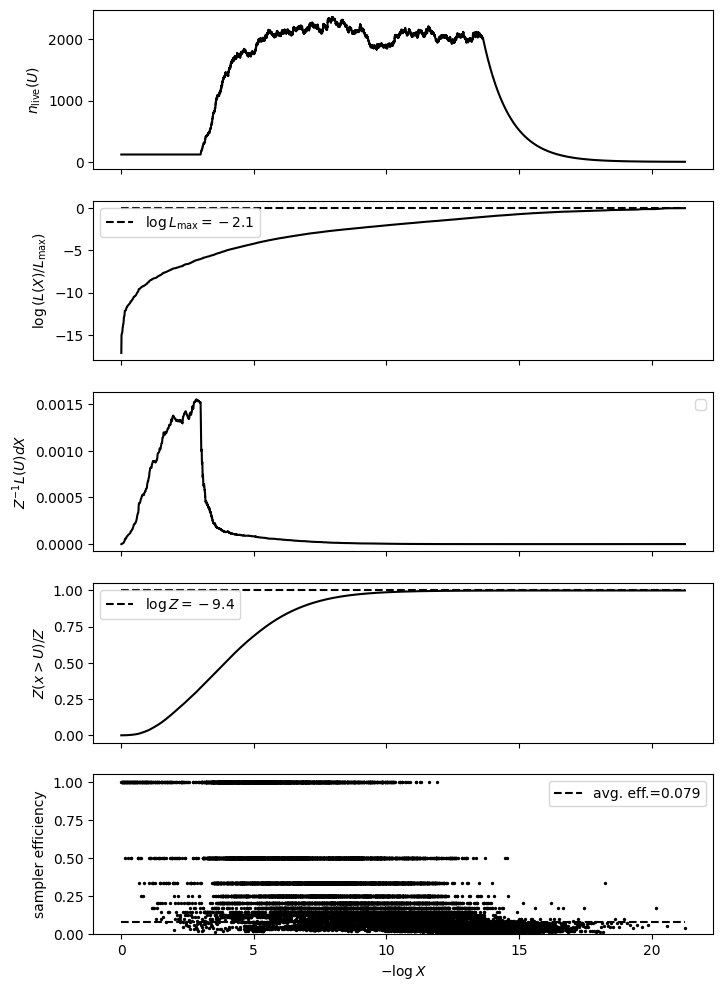

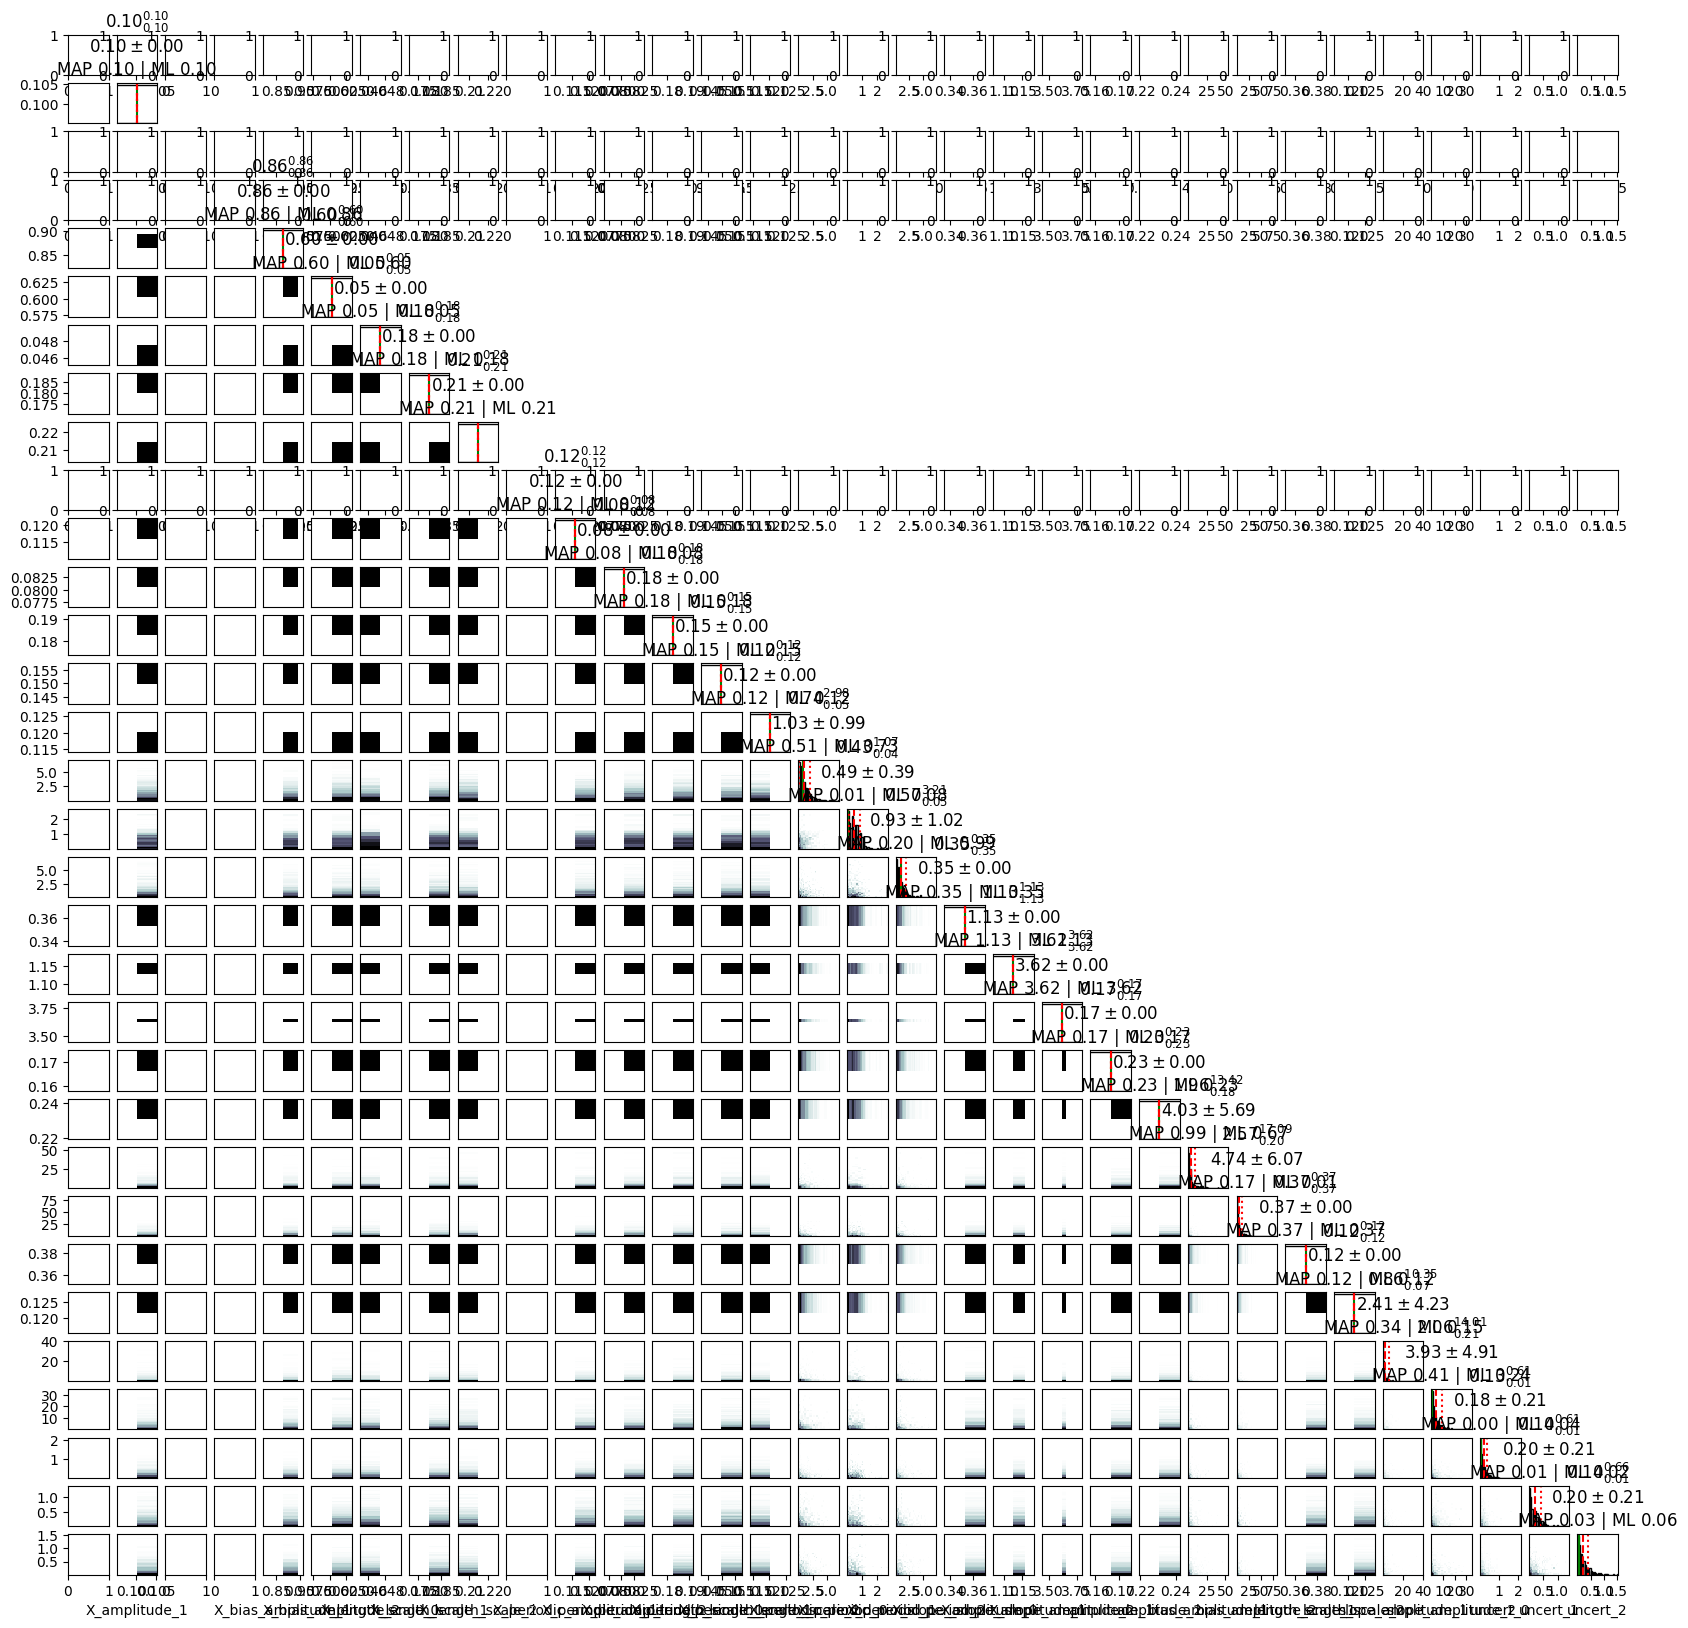

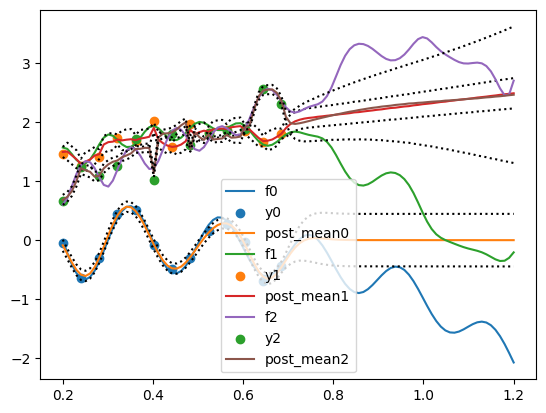

In [5]:
from itertools import permutations

# True logZ=-29.66 +- 0.11
# False logZ=-30.45 +- 0.1
for perm in list(permutations(list(range(y_obs.shape[1])), y_obs.shape[1]))[:1]:
    print(f"Permutation: {perm}")
    perm_indices = jnp.asarray(perm)
    gpar = GPAR(X=x_obs[:, None], Y=y_obs[:, perm_indices], Y_var=y_obs_var[:, perm_indices], markov_ndims=1,
                replace=True)
    gpar.sanity_check()
    results, params = gpar.fit()

    post_mean, post_var = gpar.posterior_predictive_f(results=results, params=params, Xstar=x[:, None],
                                                      map_estimate=False)

    # Plot posterior
    for i in range(3):
        plt.plot(x, f[:, i], label='f{}'.format(i))
        plt.scatter(x_obs, y_obs[:, i], label='y{}'.format(i))
        plt.plot(x, post_mean[:, i], label='post_mean{}'.format(i))
        plt.plot(x, post_mean[:, i] + jnp.sqrt(post_var[:, i]), ls='dotted', c='black')
        plt.plot(x, post_mean[:, i] - jnp.sqrt(post_var[:, i]), ls='dotted', c='black')
        plt.legend()
    plt.show()

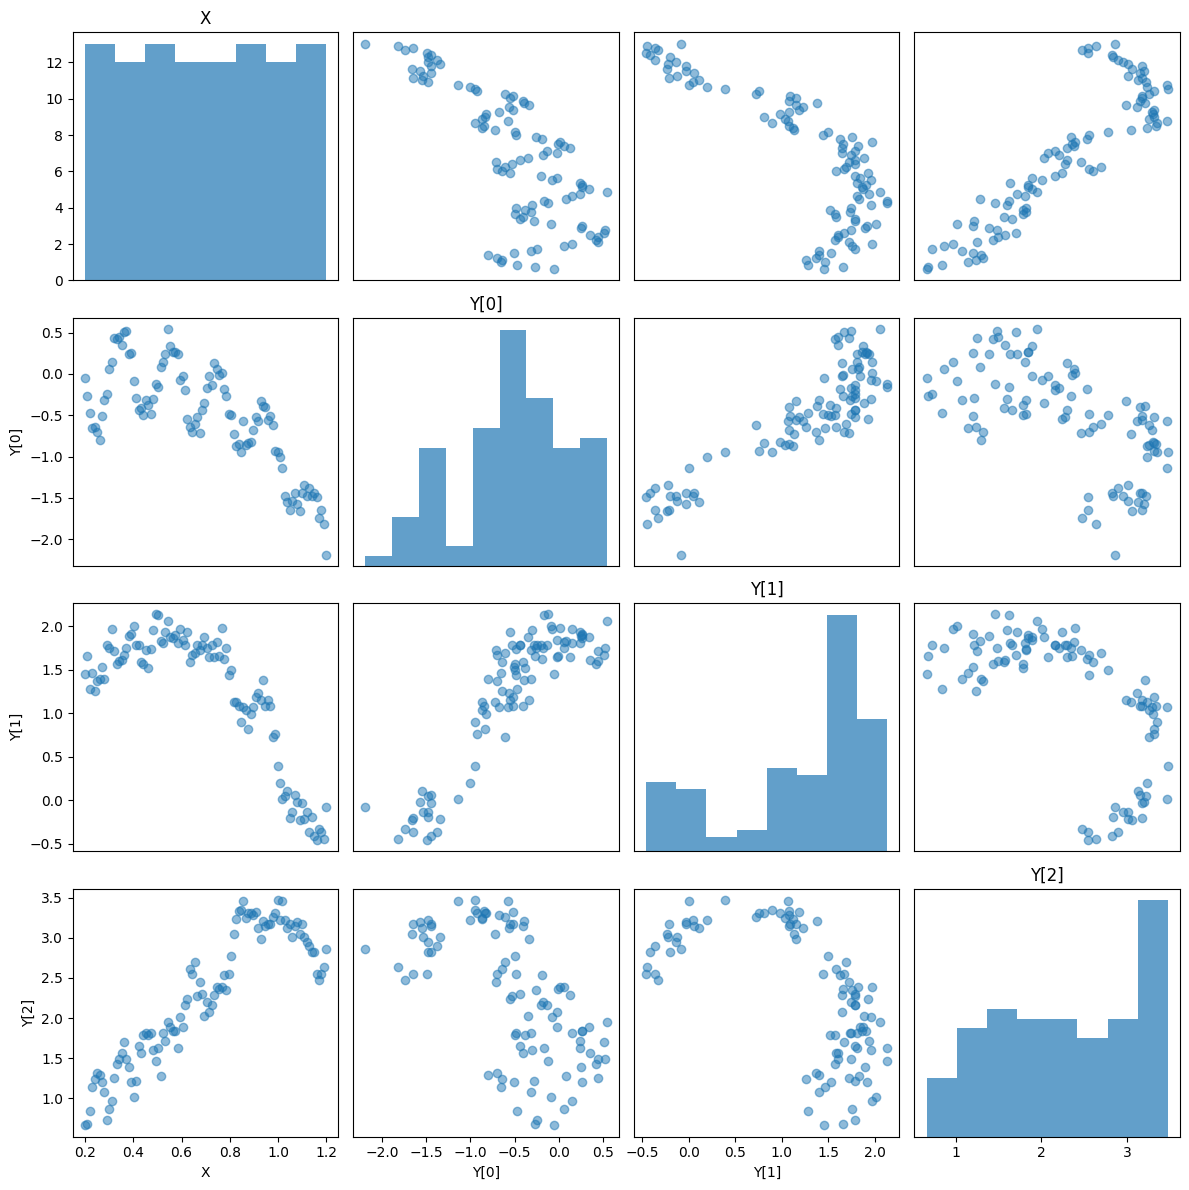

In [6]:

import matplotlib.pyplot as plt


def pair_plot(data_dict):
    """
    Generate a pair plot from a dictionary of data.
    
    Parameters:
    - data_dict: Dict[str, np.ndarray] where each array is of shape (N, D_i)
    """
    # Flatten the dictionary to get a list of all (label, data) pairs.
    all_data = []
    for key, array in data_dict.items():
        if len(array.shape) == 1 or array.shape[1] == 1:  # 1D data
            all_data.append((key, array))
        else:  # 2D data
            for idx in range(array.shape[1]):
                label = f"{key}[{idx}]"
                all_data.append((label, array[:, idx]))

    n = len(all_data)

    # Create a grid of subplots.
    fig, axs = plt.subplots(n, n, figsize=(12, 12))

    # Iterate over pairs of data to populate the grid.
    for i, (label_i, data_i) in enumerate(all_data):
        for j, (label_j, data_j) in enumerate(all_data):
            ax = axs[i, j]

            if i == j:  # Diagonal
                ax.hist(data_i, bins='auto', alpha=0.7)
                ax.set_title(label_i)
            else:  # Off-diagonal
                ax.scatter(data_j, data_i, alpha=0.5)
                if i == n - 1:  # Only label the bottom-most subplots
                    ax.set_xlabel(label_j)
                if j == 0:  # Only label the left-most subplots
                    ax.set_ylabel(label_i)

            # Hide axis labels/ticks for other subplots for clarity.
            if i != n - 1:
                ax.set_xticks([])
            if j != 0:
                ax.set_yticks([])

    plt.tight_layout()
    plt.show()


# Example Usage:
data = {
    "X": x,
    "Y": y
}

pair_plot(data)
